# Análisis mensual de categorías vía MCP


Este notebook usa el cliente oficial `mcp` para conectarse al servidor expuesto en `http://develnas:3080/mcp/`,
solicitar el informe de categorías mes a mes y visualizar los totales acumulados.

1. Instala las dependencias si aún no cuentas con ellas.
2. Asegúrate de que el endpoint MCP esté accesible.
3. Ejecuta el flujo de descarga y graficado para revisar los resultados.


In [ ]:
# Ejecuta esta celda solo si necesitas instalar dependencias adicionales.
%pip install --quiet mcp pandas matplotlib python-dateutil


In [1]:
import asyncio
from contextlib import asynccontextmanager
from typing import Any, Iterable, List, Optional

import pandas as pd
import matplotlib.pyplot as plt
import json

try:
    from mcp import ClientSession, types
    from mcp.client.streamable_http import streamablehttp_client
except ImportError as exc:
    raise RuntimeError("Instala el paquete `mcp` (por ejemplo, `pip install mcp`).") from exc

plt.style.use("seaborn-v0_8")
pd.options.display.float_format = "{:.2f}".format

MCP_ENDPOINT = "http://develnas:3080/mcp/"


In [2]:
# Permite usar await en celdas individuales.
%autoawait asyncio


In [3]:
@asynccontextmanager
async def mcp_session(endpoint: str = MCP_ENDPOINT):
    """Administra una sesión MCP vía StreamableHTTP."""
    async with streamablehttp_client(endpoint) as (read, write, _get_session_id):
        async with ClientSession(read, write) as session:
            await session.initialize()
            yield session

def extract_json_payload(result: Any) -> Any:
    """Obtiene contenido estructurado (JSON) de una respuesta MCP.
    Devuelve `None` si no se encuentra payload."""
    if result is None:
        return None
    structured = getattr(result, "structuredContent", None)
    if structured:
        candidates = structured if isinstance(structured, list) else [structured]
        for candidate in candidates:
            if hasattr(candidate, "model_dump"):
                dumped = candidate.model_dump()
                if dumped is not None:
                    return dumped
            data = getattr(candidate, "data", None) or getattr(candidate, "value", None)
            if data is not None:
                return data
        if isinstance(structured, (dict, list)):
            return structured
    elif hasattr(result, "content"):
        contents = result.content
        all_json = []
        for block in contents if isinstance(contents, list) else [contents]:
            json_ = json.loads(getattr(block, "text", "{}"))
            all_json.extend(json_)
        return all_json
    for block in getattr(result, "content", []) or []:
        if hasattr(types, 'JsonContent') and isinstance(block, types.JsonContent):
            if getattr(block, 'json', None) is not None:
                return block.json
        if hasattr(block, "model_dump"):
            dumped = block.model_dump()
            if dumped is not None:
                return dumped.get("json") or dumped
        data = getattr(block, "data", None) or getattr(block, "value", None)
        if data is not None:
            return data
    if hasattr(result, "model_dump"):
        return result.model_dump()
    return result

async def fetch_months(session: ClientSession, max_months: Optional[int] = None) -> List[str]:
    """Obtiene los meses disponibles usando la herramienta get_transactions."""
    tool_result = await session.call_tool("get_transactions", arguments={})
    transactions = extract_json_payload(tool_result) or []
    if isinstance(transactions, dict):
        transactions = transactions.values()
    months = sorted({str(item.get("fecha"))[:7] for item in transactions if isinstance(item, dict) and item.get("fecha")} , reverse=True)
    if max_months is not None:
        months = months[:max_months]
    return list(reversed(months))

async def fetch_category_report_by_month(session: ClientSession, months: Iterable[str]) -> pd.DataFrame:
    """Consulta get_category_report por mes y construye un DataFrame."""
    rows = []
    for month in months:
        tool_result = await session.call_tool("get_category_report", arguments={"month": month})
        categories = extract_json_payload(tool_result) or []
        if isinstance(categories, dict):
            categories = categories.values()
        for category in categories:
            if not isinstance(category, dict):
                continue
            name = category.get("name") or f"Categoría {category.get('id')}"
            total = float(category.get("total") or 0)
            rows.append({"month": month, "category": name, "total": total})
    return pd.DataFrame(rows)

async def load_monthly_data(endpoint: str = MCP_ENDPOINT, max_months: int = 12) -> pd.DataFrame:
    """Carga los datos de categorías por mes en un DataFrame listo para análisis."""
    async with mcp_session(endpoint) as session:
        months = await fetch_months(session, max_months=max_months)
        if not months:
            raise ValueError("No se encontraron meses en la base de datos.")
        df = await fetch_category_report_by_month(session, months)
    if df.empty:
        raise ValueError("El servidor MCP devolvió informes vacíos.")
    df['month'] = pd.to_datetime(df['month'], format="%Y-%m")
    return df.sort_values(['month', 'category']).reset_index(drop=True)


In [4]:
# Descarga los datos (ajusta max_months si deseas más historial).
try:
    raw_df = await load_monthly_data(max_months=12)
except ValueError as exc:
    print(f'Aviso: {exc}')
    raw_df = pd.DataFrame(columns=['month', 'category', 'total'])

if raw_df.empty:
    print('No hay datos disponibles para construir el análisis mensual.')
else:
    raw_df.assign(month=raw_df['month'].dt.strftime('%Y-%m')).head()

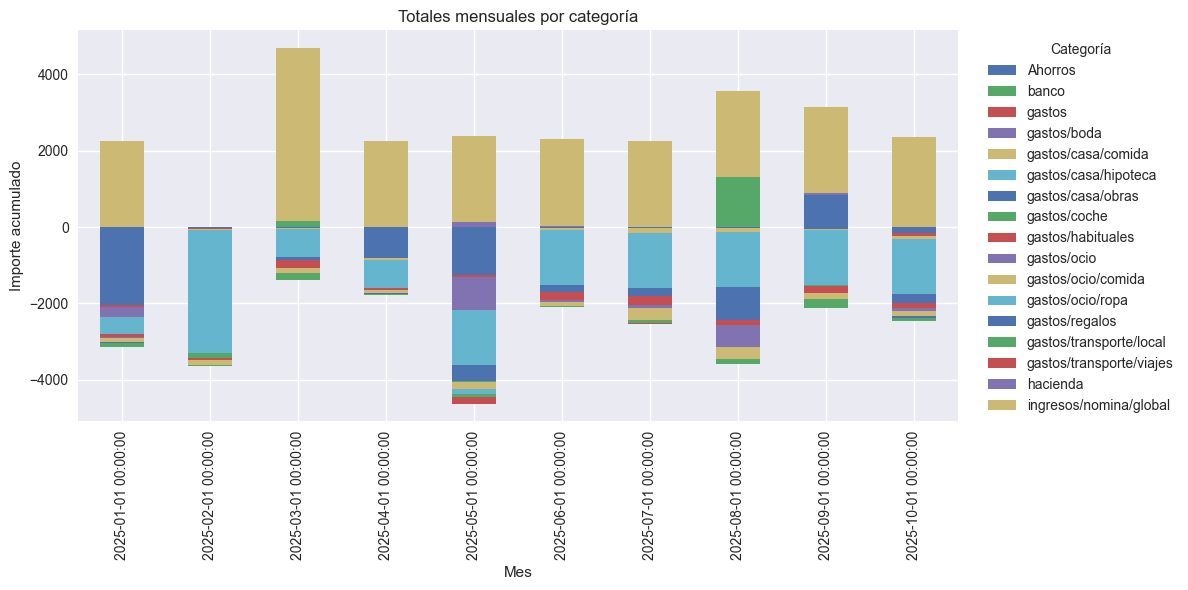

In [5]:
# Genera un gráfico stacked bar con los totales por categoría y mes.
if raw_df.empty:
    print('Sin datos para graficar. Asegúrate de tener movimientos y categorías en el servidor MCP.')
else:
    monthly_totals = (
        raw_df
        .pivot_table(index='month', columns='category', values='total', aggfunc='sum')
        .fillna(0)
        .sort_index()
    )

    fig, ax = plt.subplots(figsize=(12, 6))
    monthly_totals.plot(kind='bar', stacked=True, ax=ax)
    ax.set_title('Totales mensuales por categoría')
    ax.set_xlabel('Mes')
    ax.set_ylabel('Importe acumulado')
    ax.legend(title='Categoría', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    summary_table = monthly_totals.copy()
    summary_table['Total'] = summary_table.sum(axis=1)
    summary_table.index = summary_table.index.to_series().dt.strftime('%Y-%m')
    summary_table


In [6]:
# Tabla de apoyo con el total mensual sumado y totales por categoría.
if raw_df.empty:
    print('Sin datos para mostrar la tabla de resumen.')
elif 'summary_table' not in locals():
    print('Ejecuta primero la celda de gráficos para construir `summary_table`.')
else:
    summary_table


In [7]:
summary_table

category,Ahorros,banco,gastos,gastos/boda,gastos/casa/comida,gastos/casa/hipoteca,gastos/casa/obras,gastos/coche,gastos/habituales,gastos/ocio,gastos/ocio/comida,gastos/ocio/ropa,gastos/regalos,gastos/transporte/local,gastos/transporte/viajes,hacienda,ingresos/nomina/global,Total
month,,,,,,,,,,,,,,,,,,
2025-01,-2036.20,0.00,-55.50,-271.91,-1.40,-422.04,0.00,0.00,-99.55,-6.70,-115.77,0.00,-31.49,-100.08,0.00,0.00,2261.00,-879.64
2025-02,-30.00,0.00,-30.00,0.00,-19.53,-3225.07,0.00,-125.24,-37.37,-16.00,-122.32,-5.00,0.00,-33.92,0.00,0.00,0.00,-3644.45
2025-03,-30.00,157.27,0.00,0.00,-30.42,-736.49,-75.97,0.00,-194.14,0.00,-138.28,0.00,0.00,-171.44,-12.21,0.00,4522.00,3290.32
2025-04,-810.96,0.00,-12.02,0.00,-31.17,-736.49,0.00,0.00,-64.17,0.00,-59.90,0.00,-35.00,-39.86,0.00,0.00,2261.00,471.43
2025-05,-1256.52,0.00,-47.98,-868.46,0.00,-1436.49,-427.18,-21.50,-1.99,0.00,-178.80,-126.82,0.00,-84.64,-171.45,129.41,2261.00,-2231.42
2025-06,-30.00,0.00,0.00,29.95,-44.95,-1436.49,-183.77,0.00,-211.50,-52.28,-109.45,0.00,0.00,-32.89,0.00,0.00,2261.00,189.62
2025-07,-30.00,0.00,0.00,0.00,-123.57,-1436.49,-223.68,0.00,-216.95,-83.49,-316.95,0.00,0.00,-73.13,-27.00,0.00,2261.00,-270.26
2025-08,-30.00,1310.27,0.00,0.00,-99.27,-1436.49,-875.46,0.00,-121.99,-576.56,-302.83,0.00,0.00,-131.15,-2.60,0.00,2261.00,-5.08
2025-09,-40.47,0.00,-12.00,0.00,-18.20,-1436.49,827.35,-43.75,-167.47,58.05,-167.12,0.00,-8.50,-215.22,0.00,0.00,2261.00,1037.18


In [8]:
# Gráfico interactivo: selecciona las categorías a mostrar.
try:
    import ipywidgets as widgets
    from IPython.display import display
except Exception as exc:
    raise RuntimeError("Instala ipywidgets: pip install ipywidgets") from exc

if raw_df.empty:
    print('Sin datos para graficar. Asegúrate de tener movimientos y categorías en el servidor MCP.')
else:
    # Construye la tabla pivot (mes x categoría).
    monthly_totals = (
        raw_df
        .pivot_table(index='month', columns='category', values='total', aggfunc='sum')
        .fillna(0)
        .sort_index()
    )

    monthly_totals_plot = monthly_totals.copy()
    monthly_totals_plot.index = monthly_totals_plot.index.to_series().dt.strftime('%Y-%m')

    categories = list(monthly_totals_plot.columns)
    if not categories:
        print('No hay categorías para mostrar.')
    else:
        selector = widgets.SelectMultiple(
            options=categories,
            value=tuple(categories),
            description='Categorías',
            rows=min(10, len(categories)),
            layout=widgets.Layout(width='40%')
        )

        out = widgets.Output()

        def plot_selected(selected):
            with out:
                out.clear_output(wait=True)
                sel = list(selected) if selected else []
                if not sel:
                    print('Selecciona al menos una categoría para graficar.')
                    return
                fig, ax = plt.subplots(figsize=(12, 6))
                monthly_totals_plot[sel].plot(kind='line', marker='o', ax=ax)
                ax.set_title('Evolución mensual por categoría')
                ax.set_xlabel('Mes')
                ax.set_ylabel('Importe')
                ax.legend(title='Categoría', bbox_to_anchor=(1.02, 1), loc='upper left')
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

        selector.observe(lambda change: plot_selected(change['new']), names='value')
        display(widgets.HBox([selector, out]))
        # Dibujar inicialmente con todas las categorías seleccionadas
        plot_selected(selector.value)
